In [114]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

titanic_df = pd.read_csv('train.csv')
titanic_df = titanic_df.reindex(np.random.permutation(titanic_df.index))


In [115]:
def preprocess_features(titanic_df):
    """Prepares input features from titanic training data set.

  Args:
    titanic_df : A Pandas DataFrame expected to contain data
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
    selected_features = titanic_df[
        ['Age',
         'Fare',
         'Pclass',
         'Sex',
         'Embarked',
         'Cabin'
        ]]
    preprocessed_features = selected_features.copy()
    preprocessed_features['Age'].fillna(np.mean(preprocessed_features['Age']), inplace=True)
    preprocessed_features['Sex'] = [1 if  sex == 'female' else 0 for sex in preprocessed_features['Sex']]
    preprocessed_features['Fare'] = np.log(preprocessed_features['Fare'] + 1)
    preprocessed_features['Pclass'] = preprocessed_features['Pclass'] - 1
    preprocessed_features['Embarked'].fillna("S", inplace=True)
    preprocessed_features['Cabin_specified'] = [0 if cabin == False else 1 for cabin in preprocessed_features['Cabin'].isnull()]
    preprocessed_features['Cabin'].fillna("Na", inplace=True)
    preprocessed_features['Cabin'] =preprocessed_features['Cabin'].astype(str).str[0]
    
    return preprocessed_features

def preprocess_targets(titanic_df):
    """ Prepares target features from titanic df
    
    Args:
        titanic_df: A Pandas DataFrame expected to contain data
    Returns:
        A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    output_targets['Survived'] = titanic_df['Survived']
    return output_targets

In [116]:
#choose 70% for our training data and 30% for validation
training_examples = preprocess_features(titanic_df).head(625)
training_targets = preprocess_targets(titanic_df).head(625)

validation_examples = preprocess_features(titanic_df).tail(266)
validation_targets = preprocess_targets(titanic_df).tail(266)

#Check that we preprocessed our inputs correctly
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
display.display(training_examples.head())

Training examples summary:


,Age,Fare,Pclass,Sex,Cabin_specified
count,625.0,625.0,625.0,625.0,625.0
mean,29.9,2.9,1.3,0.4,0.8
std,13.0,1.0,0.8,0.5,0.4
min,0.4,0.0,0.0,0.0,0.0
25%,23.0,2.2,1.0,0.0,1.0
50%,29.7,2.7,2.0,0.0,1.0
75%,36.0,3.4,2.0,1.0,1.0
max,71.0,6.2,2.0,1.0,1.0


Validation examples summary:


,Age,Fare,Pclass,Sex,Cabin_specified
count,266.0,266.0,266.0,266.0,266.0
mean,29.2,3.0,1.3,0.4,0.8
std,13.0,1.0,0.9,0.5,0.4
min,0.8,0.0,0.0,0.0,0.0
25%,21.0,2.2,0.0,0.0,1.0
50%,29.7,2.8,2.0,0.0,1.0
75%,33.8,3.6,2.0,1.0,1.0
max,80.0,6.2,2.0,1.0,1.0


Training targets summary:


,Survived
count,625.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,Survived
count,266.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


,Age,Fare,Pclass,Sex,Embarked,Cabin,Cabin_specified
303,29.7,2.6,1,1,Q,E,0
731,11.0,3.0,2,0,C,N,1
784,25.0,2.1,2,0,S,N,1
533,29.7,3.2,2,1,C,N,1
617,26.0,2.8,2,1,S,N,1


In [134]:
#Create the feature columns for our Estimator
def construct_feature_columns():
    # create categorical columns
    sex_column = tf.feature_column.categorical_column_with_identity(key='Sex', num_buckets=2)
    Pclass_column = tf.feature_column.categorical_column_with_identity(key='Pclass', num_buckets=3)
    embarked_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key='Embarked',
        vocabulary_list=["C", "S", "Q"])
    cabin_specified_column = tf.feature_column.categorical_column_with_identity(key='Cabin_specified', num_buckets=2)
    cabin_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key='Cabin',
        vocabulary_list=["N", "A", "B", "C", "D", "E", "F", "G", "T"])
    
    # create numericalcolumns
    fare_column = tf.feature_column.numeric_column('Fare')
    
    # create Binned columns
    age_column = tf.feature_column.numeric_column('Age')
    bucketized_age_column = tf.feature_column.bucketized_column(
        source_column = age_column,
        boundaries = [5, 10, 17, 25, 35, 50, 65]
    )
    
    feature_columns = set([sex_column, Pclass_column, bucketized_age_column, 
                           embarked_column, cabin_specified_column])
    return(feature_columns)

In [135]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Input function for our Estimatos.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [136]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    regularization_strength,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear classification model.
    
    We also print out training progress information,
    as well as a plot of the training and validation loss over time.
  
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing one or more columns from
          `titanic_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `titanic_df` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
          `titanic_df` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
          `titanic_df` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """
    periods = 10
    steps_per_period = steps / periods
    
    # We use gradient descent for our model
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    # We will use Logistic Regression to classify our data
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(),
        #model_dir="/home/juliandiaz1994/ml_piscine/titanic/tensorboard/titanic",
        optimizer=my_optimizer
    )
    
    # We define input functions for when we call our classifier's train and predict methods
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Survived"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Survived"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Survived"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    
    for i in range(periods):
        # Train the model
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        # get model's predictions for training data
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        
        # get model's prediction for validation data
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        # calculate log loss of our training and validation data
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        # print losses for our data
        print("Period: %.02d ---- training loss: %.02f , validation loss: %.02f" %
              (i, training_log_loss, validation_log_loss))
        
        # add losses to lists
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Finished training")
    
    # output graph of loss metrics
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
Period: 00 ---- training loss: 0.64 , validation loss: 0.64
Period: 01 ---- training loss: 0.60 , validation loss: 0.60
Period: 02 ---- training loss: 0.58 , validation loss: 0.58
Period: 03 ---- training loss: 0.56 , validation loss: 0.56
Period: 04 ---- training loss: 0.55 , validation loss: 0.55
Period: 05 ---- training loss: 0.54 , validation loss: 0.54
Period: 06 ---- training loss: 0.53 , validation loss: 0.53
Period: 07 ---- training loss: 0.52 , validation loss: 0.52
Period: 08 ---- training loss: 0.51 , validation loss: 0.51
Period: 09 ---- training loss: 0.50 , validation loss: 0.51
Finished training


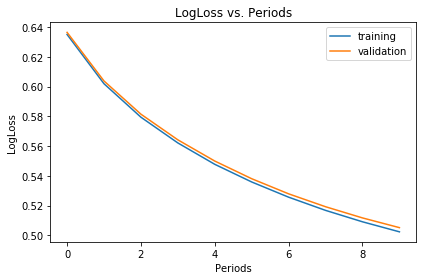

In [143]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.00005,
    steps=14000,
    batch_size=10,
    regularization_strength= 0.01,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [153]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Survived"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print(evaluation_metrics)

AUC on the validation set: 0.84
Accuracy on the validation set: 0.81
{'accuracy': 0.8082707, 'accuracy_baseline': 0.60902256, 'auc': 0.84007, 'auc_precision_recall': 0.82494676, 'average_loss': 0.50522, 'label/mean': 0.39097744, 'loss': 0.50522, 'precision': 0.93442625, 'prediction/mean': 0.3760002, 'recall': 0.5480769, 'global_step': 14000}


## Predictions

In [147]:
test_data = pd.read_csv('test.csv')
test_features = preprocess_features(test_data)

In [219]:
predict_test_input_fn = lambda: my_input_fn(test_features, 
                                                    test_features["Sex"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
predictions = linear_classifier.predict(input_fn=predict_test_input_fn)


In [220]:
results = [item['probabilities'][0] for item in predictions]
results = [0 if item > 0.609 else 1 for item in results]
results

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,


In [221]:
predictions = pd.DataFrame()
predictions["PassengerId"] = test_data["PassengerId"]
predictions["Survived"] = results
predictions = predictions.set_index('PassengerId')
predictions

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [222]:
predictions.to_csv("Predictions.csv")

In [223]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.7,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.7,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.3,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,nan,0,0,A.5. 3236,8.1,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,nan,0,0,359309,8.1,NaN,S
